# Generating Synthetic Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [2]:
df_orl = pd.read_csv("data/parameter_igt_orl.csv")
df_orl["subjID_label"] = df_orl["subjID"].astype("category").cat.codes # number label for old/young
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-,subjID_label
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581,0
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598,0
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077,0
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455,0
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241,0


## Fitting distributions to the parameters

The [Beta(a,B) distribution](https://en.wikipedia.org/wiki/Beta_distribution) can be used to model a large variety of distributions.  
It has shape parameters a and B, and location/scale parameters.  

### Modelling a single parameter

In [3]:
a, b, loc, scale = beta.fit(df_orl["BetaP"])
a, b, loc, scale

(68.88143534616461, 877.7287713924625, -46.975479728775724, 645.7067406640599)

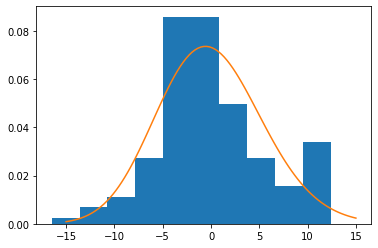

In [4]:
x = np.linspace(-15, 15, 100)
y = beta.pdf(x, a,b,loc=loc,scale=scale)

plt.hist(df_orl["BetaP"], density=True)
plt.plot(x, y)
plt.show()

### Applying to all parameters

First we define a function to get the beta parameters

In [5]:
def fit_beta(s: pd.Series):
    a, b, loc, scale = beta.fit(s)
    return pd.Series({
        "a": a,
        "b": b,
        "loc": loc,
        "scale": scale
        })

fit_beta(df_orl["BetaP"])

a         68.881435
b        877.728771
loc      -46.975480
scale    645.706741
dtype: float64

Then we can apply this accross all of our parameters

In [6]:
%%capture --no-stdout --no-display

beta_params = df_orl[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params

,A+,A-,K,BetaF,BetaP
a,1.741863e+00,1.277197,1.159286,1.534507e+07,68.881435
b,3.585195e+07,14.350636,2.058774,2.376500e+02,877.728771
loc,3.934748e-02,0.020270,0.010321,-1.091407e+06,-46.975480
scale,4.743963e+06,0.751762,2.299712,1.091425e+06,645.706741


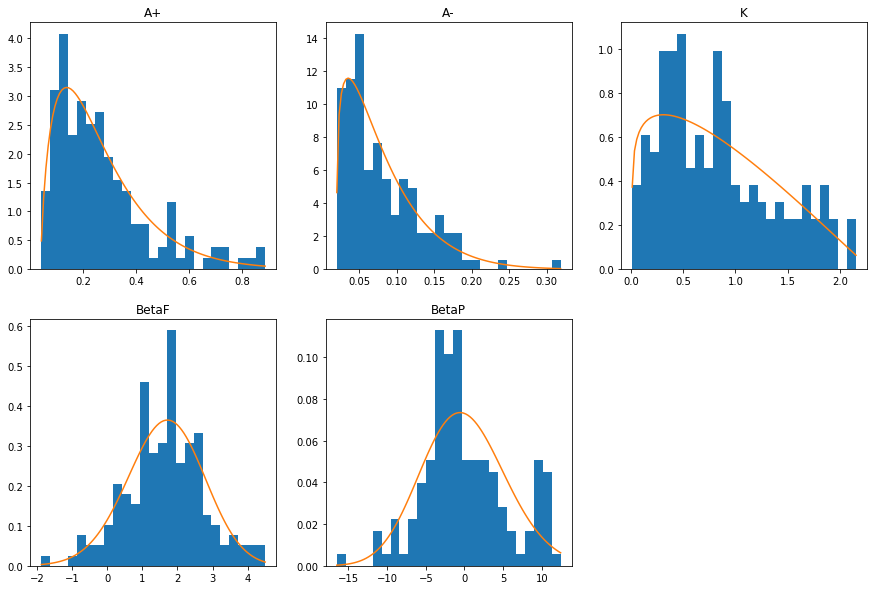

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(beta_params.columns):
    row, col = divmod(i, 3)
    b_params = beta_params[param]

    # Generate points to draw beta
    x = np.linspace(df_orl[param].min(), df_orl[param].max(), 100)
    y = beta.pdf(x, b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"])

    # Draw plots
    ax[row, col].hist(df_orl[param], density=True, bins=25)
    ax[row, col].plot(x, y)
    
    # Formatting
    ax[row, col].set_title(param)
    
# Hide unused plot
ax[1, 2].set_visible(False)

plt.show()

### Generating new data

By modelling these parameters, we can create new data by sampling from their distributions.  
For now we assume that each parameter is independent, though this is probably not the case.  
Here we generate 5000 fake data points.  

In [8]:
synth_data = pd.DataFrame()
for param in beta_params.columns:
    b_params = beta_params[param]
    sample = beta.rvs(b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"], size=5000)
    synth_data[param] = sample
    
synth_data.head()

,A+,A-,K,BetaF,BetaP
0,0.196847,0.073450,0.732564,2.104939,3.583325
1,0.155199,0.036424,0.049624,2.710226,-5.089362
2,0.121938,0.145270,0.805620,-1.000750,1.666814
3,0.339310,0.192746,0.620419,1.657040,1.894229
4,0.273036,0.150999,0.610558,2.429279,4.319846


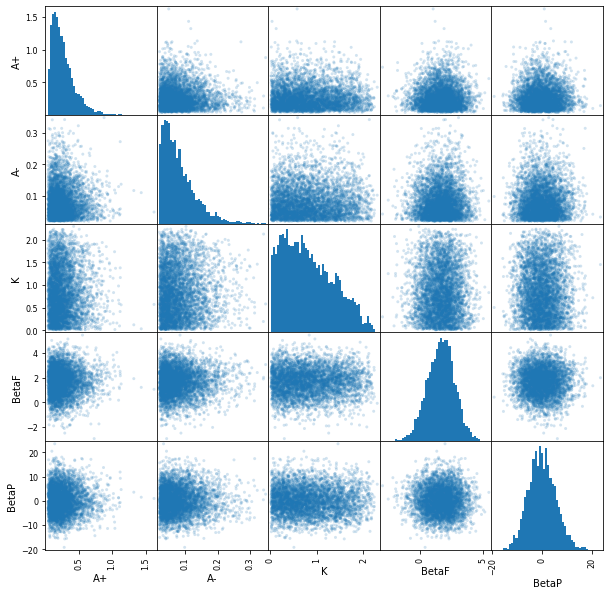

In [9]:
pd.plotting.scatter_matrix(synth_data, figsize=(10,10), hist_kwds=dict(bins=50), alpha=0.2)
plt.show()

### Modelling the smaller groups

As we saw when we explored the data, the young and old groups differ quite a bit, and the old group could be clustered into two sets.

#### Young

In [10]:
%%capture --no-stdout --no-display

df_orl_young = df_orl[df_orl["subjID"] == "young"]
beta_params_young = df_orl_young[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_young

,A+,A-,K,BetaF,BetaP
a,3.107816,0.915963,1.666190,44457.188518,2913.598741
b,76.070238,2.257807,2.562542,308.849573,578148.025209
loc,0.028411,0.021939,0.054638,-2736.611710,-166.173438
scale,4.404843,0.199791,1.428159,2757.184760,32987.037332


#### Old

In [11]:
%%capture --no-stdout --no-display

df_orl_old = df_orl[df_orl["subjID"] == "old"]
beta_params_old = df_orl_old[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old

,A+,A-,K,BetaF,BetaP
a,0.958313,1.213712,0.774079,8.873484e+06,1.616325
b,1.955718,11.336348,0.592393,2.703547e+02,0.912239
loc,0.057909,0.020123,-0.193459,-6.012199e+05,-17.371774
scale,0.940770,0.719350,2.348823,6.012400e+05,29.809652


In [12]:
beta_p_split = 7

Type A

In [13]:
%%capture --no-stdout --no-display

df_orl_old_a = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] <= beta_p_split)]
beta_params_old_a = df_orl_old_a[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old_a

,A+,A-,K,BetaF,BetaP
a,0.722214,0.865624,0.495562,43960.087950,13.236911
b,1.272786,3.517498,0.534283,2081.818929,9.560163
loc,0.057909,0.020484,-0.192978,-931.915178,-32.536860
scale,0.913321,0.300969,2.348342,978.343572,50.328865


Type B

In [14]:
%%capture --no-stdout --no-display

df_orl_old_b = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] > beta_p_split)]
beta_params_old_b = df_orl_old_b[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old_b

,A+,A-,K,BetaF,BetaP
a,0.699318,1.362001e+00,0.972171,0.769294,1.766948e+03
b,0.680318,1.028942e+12,0.750829,1.052466,2.673188e+07
loc,0.017114,2.812678e-02,0.842743,-0.763200,-3.383923e+01
scale,0.537328,5.020509e+10,1.292264,3.268634,6.629646e+05


#### Results

In [15]:
# Function to draw row of plots
def draw_beta_fit(beta_params_df, data_df, ax_row, y_label, ):
    for i, param in enumerate(beta_params_df.columns):
        b_params = beta_params_df[param]
    
        # Generate points to draw beta
        x = np.linspace(data_df[param].min(), data_df[param].max(), 100)[1:-1]
        y = beta.pdf(x, b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"])

        # Draw plots
        ax_row[i].hist(data_df[param], density=True, bins=25)
        ax_row[i].plot(x, y)
        
    ax_row[0].set_ylabel(y_label)

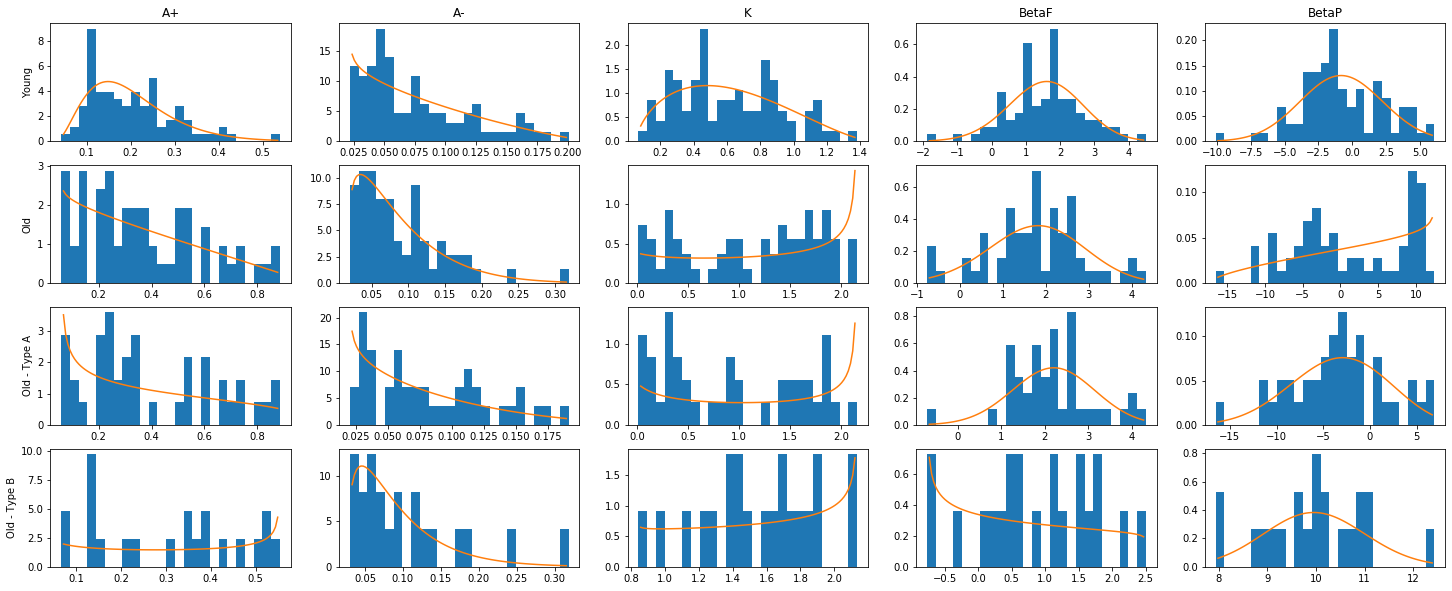

In [16]:
fig, ax = plt.subplots(4, 5, figsize=(25, 10))

# Plots
draw_beta_fit(beta_params_young, df_orl_young, ax[0], "Young")
draw_beta_fit(beta_params_old, df_orl_old, ax[1], "Old")
draw_beta_fit(beta_params_old_a, df_orl_old_a, ax[2], "Old - Type A")
draw_beta_fit(beta_params_old_b, df_orl_old_b, ax[3], "Old - Type B")

# Param titles
for i, param in enumerate(beta_params_young.columns):
    ax[0, i].set_title(param)
    
plt.show()